In [1]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests
import matplotlib.pyplot as plt
# Allow image embeding in notebook
%matplotlib inline

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


In [2]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """

    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    # Use tf.saved_model.loader.load to load the model and weights   
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    
    # get these layers that we gonna use in next step
    vgg_input_tensor = tf.get_default_graph().get_tensor_by_name(vgg_input_tensor_name)
    vgg_keep_prob_tensor = tf.get_default_graph().get_tensor_by_name(vgg_keep_prob_tensor_name)
    vgg_layer3_out_tensor = tf.get_default_graph().get_tensor_by_name(vgg_layer3_out_tensor_name)
    vgg_layer4_out_tensor = tf.get_default_graph().get_tensor_by_name(vgg_layer4_out_tensor_name)
    vgg_layer7_out_tensor = tf.get_default_graph().get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    return vgg_input_tensor, vgg_keep_prob_tensor, vgg_layer3_out_tensor, vgg_layer4_out_tensor, vgg_layer7_out_tensor

#tests.test_load_vgg(load_vgg, tf)

In [3]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # reference: http://ethereon.github.io/netscope/#/preset/vgg-16
    # https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_segmentation.html
    
    #conv2d/conv2d_transpose(inputs, filters, kernel_size, strides, padding)
    # 1x1 conv instead of fully connected layer
    vgg_layer7_conv_out = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, 1,'same')
    # 2x upsample
    vgg_layer7_transpose = tf.layers.conv2d_transpose(vgg_layer7_conv_out, num_classes, 4, 2, 'same')
    vgg_layer4_conv_out = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, 1,'same')
    # skip connection
    output1 = tf.add(vgg_layer7_transpose, vgg_layer4_conv_out)
    # same upsamele and conection 
    vgg_layer4_transpose = tf.layers.conv2d_transpose(output1, num_classes, 4, 2, 'same')
    vgg_layer3_conv_out = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, 1,'same')
    output2 = tf.add(vgg_layer4_transpose, vgg_layer3_conv_out)
    # 8x upsample back to original image
    output = tf.layers.conv2d_transpose(output2, num_classes, 16, 8, 'same')
        
    return output

#tests.test_layers(layers)

In [4]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    
    # reshape to column = num_classes = 2
    logits = tf.reshape(nn_last_layer, [-1, num_classes])
    labels = tf.reshape(correct_label, [-1, num_classes])
    # calculate cross entropy
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels, logits = logits))
    # add to summary for tensorboard
    tf.summary.scalar('loss', cross_entropy_loss)
    
    # Optimizer - Adam works better than SGD
    #train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy_loss)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)
    
    return logits, train_op, cross_entropy_loss

#tests.test_optimize(optimize)

In [5]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate, merged, train_writer):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    
    # log every 2 * 16 = 32 image
    log_batch_step = 16 
    batches = []
    loss_batch = []
    
    for epoch_i in range(epochs):
        print('Epochs %d: ' % epoch_i)
        print('---------------------')
        i = 0
        batch_i = 0
        for input_img, gt_img in get_batches_fn(batch_size):
            feed_dict = {input_image : input_img, correct_label : gt_img, keep_prob : 0.85, learning_rate : 1e-4}
            _, l, summary = sess.run([train_op, cross_entropy_loss, merged], feed_dict = feed_dict)
    
            i += 1
            if (i % log_batch_step == 0):
                batch_i += 1
                print('Minibatch loss at step %d: %f' % (batch_i, l))
                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_writer.add_summary(summary, batch_i)
                train_writer.flush()
     
    # plot batch-loss summary
    loss_plot = plt.subplot(111)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim([batches[0], batches[-1]])
    
    pass

#tests.test_train_nn(train_nn)

In [6]:
def run():
    num_classes = 2
    image_shape = (160, 576)
    data_dir = './data'
    runs_dir = './runs'
    tests.test_for_kitti_dataset(data_dir)

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/

    epochs = 10
    batch_size = 2
    
    with tf.Session() as sess:        
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)
        
        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        # Build NN using load_vgg, layers, and optimize function
        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, vgg_path)
        nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)
        
        correct_label = tf.placeholder(tf.float32, (None, None, None, num_classes))
        learning_rate = tf.placeholder(tf.float32)
        logits, train_op, cross_entropy_loss = optimize(nn_last_layer, correct_label, learning_rate, num_classes)
        
        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter('./logs', sess.graph)
        
        # initializes global variables in the graph
        sess.run(tf.global_variables_initializer())
        
        # Train NN using the train_nn function
        train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
                 correct_label, keep_prob, learning_rate, merged, train_writer)
        
        # TODO: Save inference data using helper.save_inference_samples
        helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)

        # OPTIONAL: Apply the trained model to a video

Tests Passed
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
Epochs 0: 
---------------------
Minibatch loss at step 1: 7.980023
Minibatch loss at step 2: 3.605894
Minibatch loss at step 3: 2.167993
Minibatch loss at step 4: 1.470710
Minibatch loss at step 5: 1.394178
Minibatch loss at step 6: 1.073156
Minibatch loss at step 7: 1.026151
Minibatch loss at step 8: 0.894994
Minibatch loss at step 9: 0.879914
Training Finished. Saving test images to: ./runs/1502896877.2458344


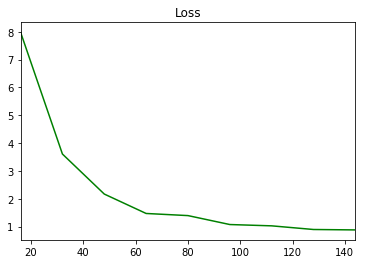

In [7]:
if __name__ == '__main__':
    run()